## Import Data From glade (on Cheyenne)
This notebook imports data from the csv generated in 00_find_data.ipynb

In [2]:
import numpy as np
import xarray as xr
import intake
import pandas as pd
import scipy
from scipy import signal
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy.random as random
import cartopy.crs as ccrs

pd.set_option('display.max_colwidth',-1)

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


Read in the list of path names to access the relevant CMIP6 historical, piControl, and SSP585 data.

In [3]:
data_list = pd.read_csv('/glade/u/home/molina/CMIP6_pathnames.csv')
data_list

,Unnamed: 0,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
0,35731,CMIP,BCC,BCC-CSM2-MR,historical,r2i1p1f1,Amon,tas,gn,NaN,v20181115,185001-201412,/glade/collections/cmip/CMIP6/CMIP/BCC/BCC-CSM2-MR/historical/r2i1p1f1/Amon/tas/gn/v20181115/tas/tas_Amon_BCC-CSM2-MR_historical_r2i1p1f1_gn_185001-201412.nc
1,36172,CMIP,BCC,BCC-CSM2-MR,historical,r1i1p1f1,Amon,tas,gn,NaN,v20181126,185001-201412,/glade/collections/cmip/CMIP6/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/Amon/tas/gn/v20181126/tas/tas_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc
2,36609,CMIP,BCC,BCC-CSM2-MR,historical,r3i1p1f1,Amon,tas,gn,NaN,v20181119,185001-201412,/glade/collections/cmip/CMIP6/CMIP/BCC/BCC-CSM2-MR/historical/r3i1p1f1/Amon/tas/gn/v20181119/tas/tas_Amon_BCC-CSM2-MR_historical_r3i1p1f1_gn_185001-201412.nc
3,37431,CMIP,BCC,BCC-CSM2-MR,piControl,r1i1p1f1,Amon,tas,gn,NaN,v20181016,185001-244912,/glade/collections/cmip/CMIP6/CMIP/BCC/BCC-CSM2-MR/piControl/r1i1p1f1/Amon/tas/gn/v20181016/tas/tas_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc
4,174777,CMIP,CAS,FGOALS-g3,historical,r2i1p1f1,Amon,tas,gn,NaN,v20190828,196001-196912,/glade/collections/cmip/CMIP6/CMIP/CAS/FGOALS-g3/historical/r2i1p1f1/Amon/tas/gn/v20190828/tas/tas_Amon_FGOALS-g3_historical_r2i1p1f1_gn_196001-196912.nc
...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,652996,ScenarioMIP,CAMS,CAMS-CSM1-0,ssp585,r1i1p1f1,Amon,tas,gn,NaN,v20190708,201501-209912,/glade/collections/cmip/CMIP6/ScenarioMIP/CAMS/CAMS-CSM1-0/ssp585/r1i1p1f1/Amon/tas/gn/v20190708/tas/tas_Amon_CAMS-CSM1-0_ssp585_r1i1p1f1_gn_201501-209912.nc
281,697364,ScenarioMIP,MRI,MRI-ESM2-0,ssp585,r1i1p1f1,Amon,tas,gn,NaN,v20190222,201501-210012,/glade/collections/cmip/CMIP6/ScenarioMIP/MRI/MRI-ESM2-0/ssp585/r1i1p1f1/Amon/tas/gn/v20190222/tas/tas_Amon_MRI-ESM2-0_ssp585_r1i1p1f1_gn_201501-210012.nc
282,697661,ScenarioMIP,MIROC,MIROC-ES2L,ssp585,r1i1p1f2,Amon,tas,gn,NaN,v20190823,201501-210012,/glade/collections/cmip/CMIP6/ScenarioMIP/MIROC/MIROC-ES2L/ssp585/r1i1p1f2/Amon/tas/gn/v20190823/tas/tas_Amon_MIROC-ES2L_ssp585_r1i1p1f2_gn_201501-210012.nc
283,697914,ScenarioMIP,MIROC,MIROC6,ssp585,r2i1p1f1,Amon,tas,gn,NaN,v20190627,201501-210012,/glade/collections/cmip/CMIP6/ScenarioMIP/MIROC/MIROC6/ssp585/r2i1p1f1/Amon/tas/gn/v20190627/tas/tas_Amon_MIROC6_ssp585_r2i1p1f1_gn_201501-210012.nc


Import BCC-CSM2-MR as a test model.

In [22]:
modelname = 'BCC-CSM2-MR'
membername = 'r1i1p1f1'
variable_id = 'tas'

In [5]:
filtereddata_list = data_list[data_list['source_id'].str.contains(modelname)]
filtereddata_list = filtereddata_list[filtereddata_list['member_id'].str.contains(membername)]

historicalpath = filtereddata_list[filtereddata_list['experiment_id'].str.contains('historical')]['path']
scenariopath = filtereddata_list[filtereddata_list['experiment_id'].str.contains('ssp585')]['path']

In [6]:
histpathname = data_list.loc[(data_list['source_id'] == modelname)&(data_list['member_id'] == membername)&(data_list['experiment_id'] == 'historical')]
projpathname = data_list.loc[(data_list['source_id'] == modelname)&(data_list['member_id'] == membername)&(data_list['experiment_id'] == 'ssp585')]

In [7]:
histds = xr.open_dataset(histpathname.path.values[0])
projds = xr.open_dataset(projpathname.path.values[0])
histds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 160, lon: 320, time: 1980)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat        (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon        (lon) float64 0.0 1.125 2.25 3.375 ... 355.5 356.6 357.8 358.9
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          Standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  2289.0
    comment:                The model integration starts from the piControl e...
    contact:                Dr. Tongwen Wu(twwu@cma.gov.cn)
    creation_date:          2018-11-26T05:08:26Z
    data_specs_version:     01.00.27
    description:      

Let's take a look at a global mean of the historical and ssp585 data.

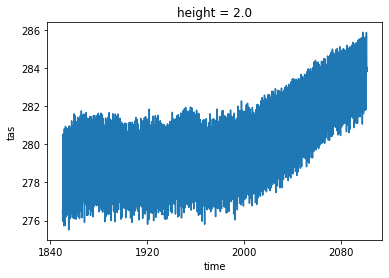

In [8]:
allds = xr.concat((histds['tas'], projds['tas']), dim='time')

allds.shape
#histds['tas'].mean(dim=['lat','lon']).plot()
#projds['tas'].mean(dim=['lat','lon']).plot()
allds.mean(dim=['lat', 'lon']).plot()

Remove the local monthly climatology from the data:

Commented:
Standardize the historical and projected data (by subtracting the local monthly climatology and then dividing by the standard deviation of the local time series).

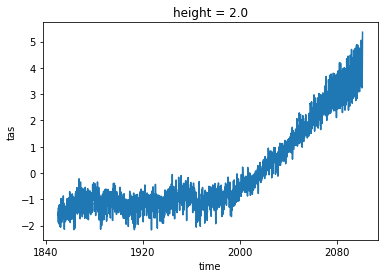

In [10]:
#find the monthly climatology for each pixel
monthly_clim = allds.groupby('time.month').mean()
#subtract the local monthly climatology
demonthlied_data = allds.groupby('time.month') - monthly_clim
#calculate the local standard deviation
# demonthlied_std = demonthlied_data.std(dim='time')
#divide the data by the standard deviation
# standardizeds = demonthlied_data/demonthlied_std

# #plot the standardized global mean time series
# standardizeds.mean(dim=['lat', 'lon']).plot()

#plot the deseasonalized global mean time series
demonthlied_data.mean(dim=['lat', 'lon']).plot()

Smooth the standardized global time series with a fourth-order polynomial.

In [11]:
#Fit a fourth-order polynomial to the global mean time series.
timeseries = np.arange(0, allds.shape[0])
smoothed_coefs = np.polyfit(np.arange(0,allds.shape[0]),demonthlied_data.mean(dim=['lat', 'lon']),4)
smoothed_vals = np.poly1d(smoothed_coefs)
#Apply polynomial over our time domain
smoothed_ds = smoothed_vals(timeseries)

Text(0.5, 1.0, 'Comparison of raw and smoothed global mean time series')

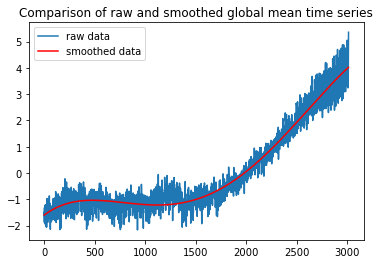

In [12]:
#plot the global mean time series and the smoothed data (shown in red)
plt.plot(timeseries,demonthlied_data.mean(dim=['lat','lon']))
plt.plot(timeseries,smoothed_ds,'r')
plt.legend(['raw data','smoothed data'])
plt.title('Comparison of raw and smoothed global mean time series')

Now, we use linear regression to explore the question, "What portion of the variability at each gridpoint can be explained by the trend?".  We're assuming that our smoothed global mean time series is a good approximation of our trend, and we'll regress this time series (our predictor) on our data at each gridpoint.  For this example, we'll use the OLS package in statsmodel, but you could use any package that can perform a straightforward linear regression.  We want our regression model to output 2 things at each gridpoint--a regression coefficient, alpha (a slope), and the residuals, beta (an intercept).  
Note that if we apply our OLS model to our anomaly data, our alphas (slopes), should be approximately zero; this will change if we apply our OLS model to the raw data.  Our betas (intercepts), should be the same either way. First we'll just do an example at a single gridpoint:

In [13]:
#To get the intercept coefficients, we need to use add_constant
x_regress_example = sm.OLS(demonthlied_data.values[:,33,33],sm.tools.add_constant(smoothed_ds)).fit()
x_regress_example.params
#version with raw data
#x_regress_example = sm.OLS(trend_3d[33,2,:],sm.tools.add_constant(data_smoothed)).fit()
#x_regress_example.params
print("alpha: ",x_regress_example.params[0],"   beta: ",x_regress_example.params[1])
print(x_regress_example.summary())

alpha:  -7.57094860692753e-07    beta:  0.527202768901518
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                 1.054e+04
Date:                Thu, 17 Oct 2019   Prob (F-statistic):               0.00
Time:                        17:08:55   Log-Likelihood:                -1861.8
No. Observations:                3012   AIC:                             3728.
Df Residuals:                    3010   BIC:                             3740.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

Then we apply the regression to each gridpoint:

In [14]:
x_dim = demonthlied_data.shape[1]
y_dim = demonthlied_data.shape[2]

alphas_all = np.zeros([x_dim,y_dim])
betas_all = np.zeros([x_dim,y_dim])
for i in np.arange(0,x_dim):
    for j in np.arange(0,y_dim):
        ij_regress = sm.OLS(demonthlied_data.values[:,i,j],sm.tools.add_constant(smoothed_ds)).fit()
        alphas_all[i,j] = ij_regress.params[0]
        betas_all[i,j] = ij_regress.params[1]

Now we can plot our alpha and beta values across the globe:

Text(0.5, 1.0, 'betas')

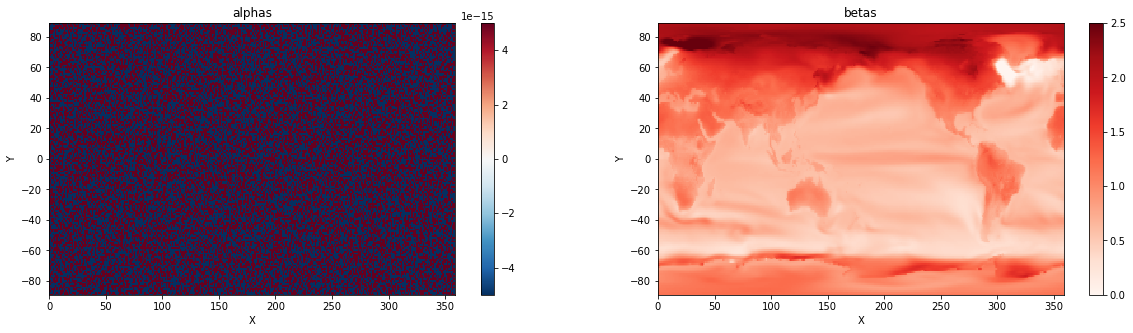

In [15]:
fig1, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
xgrid,ygrid = np.meshgrid(histds['lon'],histds['lat'])

pc1 = ax1.pcolormesh(xgrid,ygrid,alphas_all,cmap='RdBu_r',vmin=-5e-15,vmax=5e-15)
fig1.colorbar(pc1,ax=ax1)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
pc2 = ax2.pcolormesh(xgrid,ygrid,betas_all,cmap='Reds',vmin=0,vmax=2.5)
fig1.colorbar(pc2,ax=ax2)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax1.set_title('alphas')
ax2.set_title('betas')
#print(xgrid.shape)
#print(alphas_all.shape)

dependent variable has shape of  (1511,)
independent variable has shape of  (3012, 2)
regression model has shape of  (2,)
data to predict has shape of  (1511, 2)
(1511,)


Text(0.5, 1.0, 'comparison of actual data and prediction from regression')

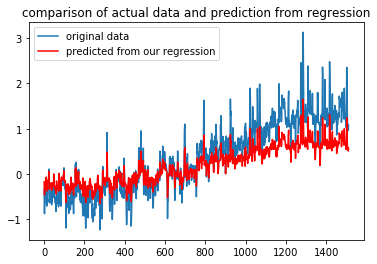

In [16]:
i = 33
j = 153
k = 1500

data_test_to_predict = sm.add_constant(demonthlied_data.values[k:-1,i,j])
print("dependent variable has shape of ",demonthlied_data.values[k:-1,i,j].shape)
print("independent variable has shape of ",sm.add_constant(smoothed_ds).shape)
print("regression model has shape of ",x_regress_example.params.shape)
print("data to predict has shape of ",data_test_to_predict.shape)
data_prediction = x_regress_example.predict(np.squeeze(data_test_to_predict))
print(data_prediction.shape)

plt.plot(demonthlied_data.values[k:-1,i,j])
plt.plot(data_prediction,'r')
plt.legend(['original data','predicted from our regression'])
plt.title('comparison of actual data and prediction from regression')

#print(histds.isel(lon=i, lat=j, time=0))

Here we save the smoothed global time series as well as the global alpha and beta arrays.

In [25]:
_ds = allds.to_dataset(name=variable_id)
_ds = _ds.drop([variable_id, ])

_ds['alpha'] = (('lat', 'lon'), alphas_all)
_ds['beta'] = (('lat', 'lon'), betas_all)
_ds[f'smoothed_{variable_id}'] = (('time', ), smoothedglobalts)

_ds.to_netcdf(f'{modelname}_{membername}_signaldata.nc')